# NIR Notebook Test
28.Nov 2023

### Big steps

1. Check NIR Arduino may need to reinstall software - see Arduino file for that (insert)
   - current arduino file - `button_nir_v_04.ino`

2. Set up a virtual Python environment for Visual Studio Code

   ```shell
   cd path/to/your/project
   
   python3 -m venv nir
   
   source nir/bin/activate
   ```

3.  Install the files below

### Packages

Built-in packages are: time, os, csv

1. pyserial
2. schedule
3. matplotlib

### Run the Notebook

1. If the first time, then you can run all
2. If you want to collect different samples you can start with 2. Serial communication with Arduino
3. Proceed cell by cell to collect data

## 1. Serial Communications
This code block below reads what your serial port the Arduino is at and prints that out. You may need to update the cell below with that information. Since on windows serial ports change frequently.

In [ ]:
import serial
import serial.tools.list_ports
def list_serial_ports():
    ports = serial.tools.list_ports.comports()
    for port in ports:
        print(port)
if __name__ == '__main__':
    list_serial_ports()

## 2. Serial communication with Arduino
1. Check the above print out
2. Find the Arduino board "SparkFun SAMD51 MicroMod" serial port "COM8" or "/dev/cu.usbmodem12301" something like these and put into the code.

In [ ]:
import time
import schedule
carry_values = []
def main_func():
    global carry_values
    try:
        # change your serial port
        #arduino = serial.Serial('COM8', 115200, timeout=1)#windows flavor
        arduino = serial.Serial('/dev/cu.usbmodem12401', 115200, timeout=1)#linux and MacOS flavor
        print('Established serial connection to Arduino')
    except Exception as e:
        print(f'Failed to connect: {e}')
        return
    arduino_data = arduino.readline()
    if not arduino_data:
        print('No data received from Arduino. Exiting...')
        arduino.close()
        return 'exit'
    decoded_values = str(arduino_data[0:len(arduino_data)].decode("utf-8"))
    list_values = decoded_values.split(',')
    list_values= list_values[:-1]
    carry_values = []
    for item in list_values:
        carry_values.append(float(item))
    print(f'Collected readings from Arduino: {carry_values}')
    arduino_data = 0
    arduino.close()
    print('Connection closed')
    print('<----------------------------->')
print('Program started')
schedule.every(5).seconds.do(main_func)
start_time = time.time()
while True:
    result = schedule.run_pending()
    if result == 'exit':
        break
    time.sleep(1)
    elapsed_time = time.time() - start_time
    if elapsed_time > 15:
        print('graph')
        print(f'Graph: {carry_values}')
        break

## 3. Initial Plot
Plots the current reading

In [ ]:
import matplotlib.pyplot as plt
#carry_values = [1021.96, 485.59, 1090.37, 413.11, 787.75, 1186.35, 437.41, 560.83, 2201.98, 416.03, 671.91, 134.69, 202.98, 146.25, 479.8, 950.51, 335.93]
x_values = [410, 435, 460, 485, 510, 535, 560, 585, 610, 645, 680, 705, 730, 760, 810, 860, 900]
plt.figure(figsize=(10,5))
plt.plot(x_values, carry_values, marker='o')
plt.title('Response over Wavelength')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Response')
plt.grid(True)
plt.show()

## 4. Saves out data to CVS text file
1. The file is named "samples_01.csv" you can change it if you want
2. You will be asked to enter the name of the material in pop-up window on the top of the notebook, enter the name make sure it is one word e.g. "yellow_cloth"
3. The info will be saved into the text file.

In [ ]:
import csv
import os
filename = 'samples_13_close.csv'
item = input('Please add a new item at the end of the list (a text string): ')
carry_values.append(item)
file_exists = os.path.isfile(filename)
with open(filename, mode='a', newline='') as file:
    writer = csv.writer(file)
    if not file_exists:
        writer.writerow(['410', '435', '460', '485', '510', '535', '560', '585', '610', '645', '680', '705', '730', '760', '810', '860', '900', 'Material', 'Additional Item'])
    writer.writerow(carry_values + [item])
print(f'Data has been saved to {filename}')

## 5. Plot of all your saved samples

Skipping row due to length mismatch: x_values length: 17, carry_values length: 0


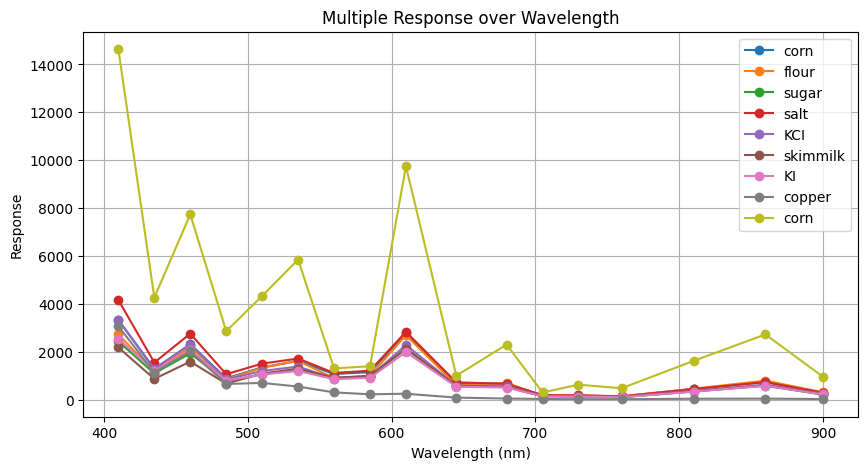

In [14]:
import csv
import os
import matplotlib.pyplot as plt
filename = 'samples_13.csv'
plt.figure(figsize=(10,5))
x_values = [410, 435, 460, 485, 510, 535, 560, 585, 610, 645, 680, 705, 730, 760, 810, 860, 900]
with open(filename, mode='r') as file:
    reader = csv.reader(file)
    for row in reader:
        try:
            carry_values = [float(value) for value in row[:-2]]  # Exclude the last two items
        except ValueError as e:
            print(f'Error converting value to float: {e}')
            continue  # Skip to the next row if there is an error converting value
        if len(x_values) != len(carry_values):
            print(f'Skipping row due to length mismatch: x_values length: {len(x_values)}, carry_values length: {len(carry_values)}')
            continue  # Skip to the next row if there is a length mismatch
        legend_item = row[-2]  # Use the second last item as legend
        plt.plot(x_values, carry_values, marker='o', label=legend_item)
plt.title('Multiple Response over Wavelength')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Response')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

## Salt Baseline

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
x_values = [410, 435, 460, 485, 510, 535, 560, 585, 610, 645, 680, 705, 730, 760, 810, 860, 900]
# Reload the dataset as the execution state was reset
file_path = 'samples_29c.csv'
data = pd.read_csv(file_path)

# Get a color palette
palette = sns.color_palette("hsv", n_colors=len(data))

# Create a plot with unique colors for each material and salt as a thick black line
plt.figure(figsize=(12, 6))

# Plot for each material with a unique color
for (index, row), color in zip(data.iterrows(), palette):
    if row['material'] == 'salt':
        # Plot 'salt' with a black, thicker line
        plt.plot(row.drop(['material', 'extra']).index, row.drop(['material', 'extra']).values, marker='o', color='black', linewidth=2.5, label=row['material'])
    else:
        # Plot other materials with unique colors
        plt.plot(row.drop(['material', 'extra']).index, row.drop(['material', 'extra']).values, marker='o', color=color, label=row['material'])

# Adding labels and title
plt.title("Comparison of Different Materials with Salt as Baseline")
plt.xlabel("Measurements")
plt.ylabel("Values")
plt.grid(True)
plt.legend()
plt.show()


## Differnces

In [2]:
pip install seaborn


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
#FOOBARED
# normalized on all of them - can we ID the material?

import pandas as pd

def load_data(file_path):
    return pd.read_csv(file_path)

def calculate_differences(data1, data2):
    # Find common materials
    common_materials = set(data1['material']).intersection(data2['material'])

    # Filter datasets for common materials
    data_common_1 = data1[data1['material'].isin(common_materials)]
    data_common_2 = data2[data2['material'].isin(common_materials)]

    # Drop non-numeric columns
    data_common_1_numeric = data_common_1.drop(['material', 'extra'], axis=1)
    data_common_2_numeric = data_common_2.drop(['material', 'extra'], axis=1)

    # Calculate differences
    differences = data_common_1_numeric.values - data_common_2_numeric.values

    # Create a DataFrame for differences
    diff_df = pd.DataFrame(differences, columns=data_common_1_numeric.columns)
    diff_df['material'] = data_common_1['material'].values
    return diff_df

# Paths to the datasets (replace with the actual paths or variable names if already loaded)
file_path_1 = 'samples_29.csv'
file_path_2 = 'samples_13.csv'

# Load datasets
data1 = load_data(file_path_1)
data2 = load_data(file_path_2)

# Calculate and display differences
diff_df = calculate_differences(data1, data2)
diff_df


KeyError: 'material'

## Sensor distancce
- 3.5 CM away the tube
- 1.3 CM away 

Paint it black